In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from pygam import LinearGAM, s, f

# Step 1: Load the Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=";")

# Step 2: Train a Model
X = data.drop("quality", axis=1)
y = data["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

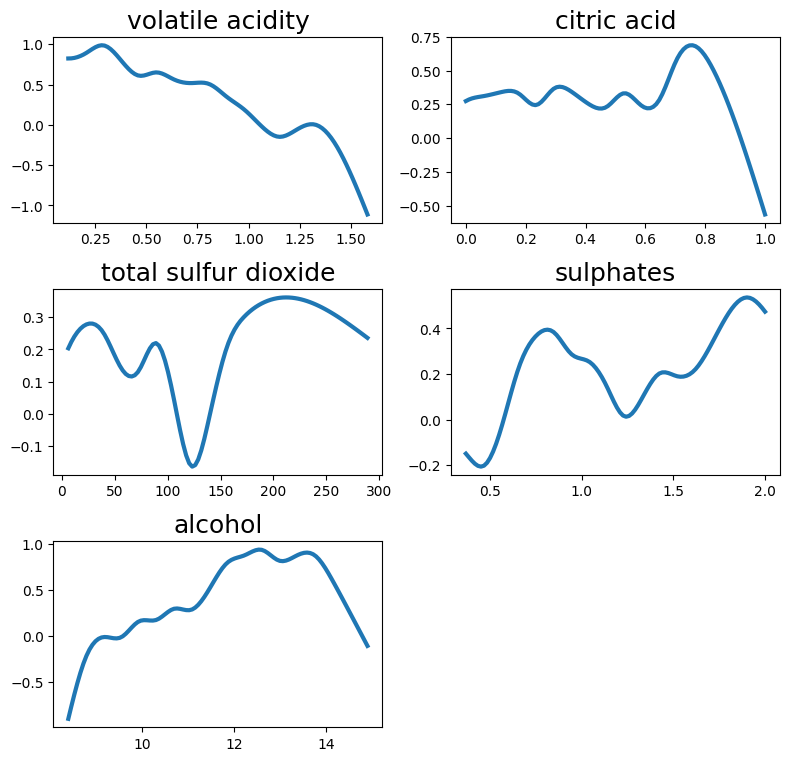

In [31]:
# Step 4: Apply GAM
# Step 4: Apply GAM

prediction = model.predict(X_train)
gam = LinearGAM( s(1) + s(2)  + s(6) + s(9) + s(10)).fit(X_train, prediction)

xxs = []
# Plot GAM
plt.figure(figsize=(8, 10))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(4, 2, i+1)
    XX = gam.generate_X_grid(term=i)
    xxs.append(XX)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX),linewidth=3)
    plt.title(data.columns[term.feature],fontsize=18)
plt.tight_layout()
plt.show()

In [55]:
# 选择一个实例进行解释
instance_idx = 0
instance = X_train.iloc[instance_idx]

# 使用GAM模型进行预测
predicted_value = gam.predict(instance.values.reshape(1, -1))[0]

# 指定要展示的特征
selected_features = [ 'volatile acidity', 'citric acid','free sulfur dioxide','total sulfur dioxide','sulphates', 'alcohol']
selected_feature_indices = [X.columns.get_loc(feature) for feature in selected_features]

# 计算每个特征的贡献
contributions = np.array([gam.partial_dependence(term=i, X=instance.values.reshape(1, -1)) for i in selected_feature_indices])

In [56]:
selected_feature_indices

[1, 2, 5, 6, 9, 10]

/tmp/ipykernel_1780481/3891750818.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axvline(instance[i], color=color, linestyle='-')
/tmp/ipykernel_1780481/3891750818.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(instance[i], contributions[idx], color=color)


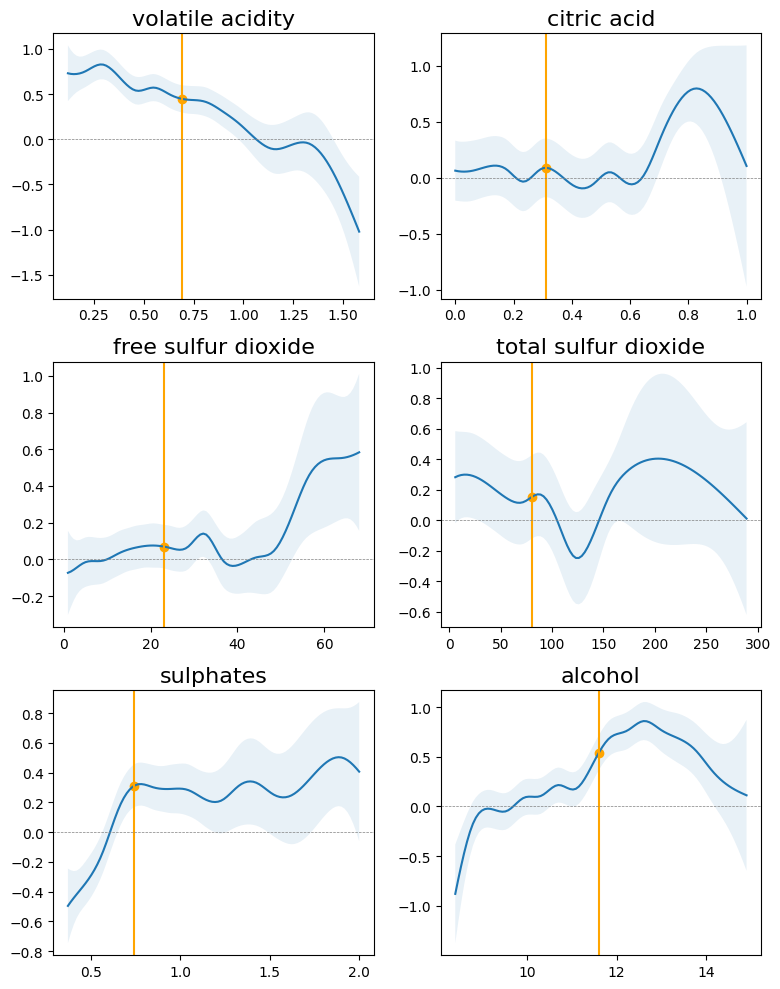

In [88]:
import matplotlib.pyplot as plt
import numpy as np
# gam = LinearGAM( s(1) + s(2)  + s(6) + s(9) + s(10)).fit(X_train, y_train)
# Train a GAM model
prediction = model.predict(X_train)

gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)).fit(X_train, prediction)

def plot_gam_contributions(gam, instance, contributions,selected_features, selected_feature_indices):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
    axes = axes.flatten()
    
    for idx, (feature, feature_idx) in enumerate(zip(selected_features, selected_feature_indices)):
        i=feature_idx
        ax = axes[idx]
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, width=0.9)
        
        
   
        ax.plot(XX[:, i], pdep)
        ax.fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.1)
        
        # Highlight the instance's specific value on the shape function
        # 高亮实例的特定值在形状函数图上的位置
        color = 'orange' if contributions[idx] >= 0 else 'green'
        ax.axvline(instance[i], color=color, linestyle='-')
        ax.scatter(instance[i], contributions[idx], color=color)
        ax.axhline(y=0, color='grey', linestyle='--',linewidth=0.5)
        
        ax.set_title(f'{feature}',fontsize=16)
    
    plt.tight_layout()
    plt.show()

# Plot the contributions
plot_gam_contributions(gam, instance, contributions,selected_features, selected_feature_indices)


/tmp/ipykernel_1780481/2958435292.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axvline(instance[feature_idx], color=color, linestyle='-')
/tmp/ipykernel_1780481/2958435292.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(instance[feature_idx], contributions[idx][0], color=color)


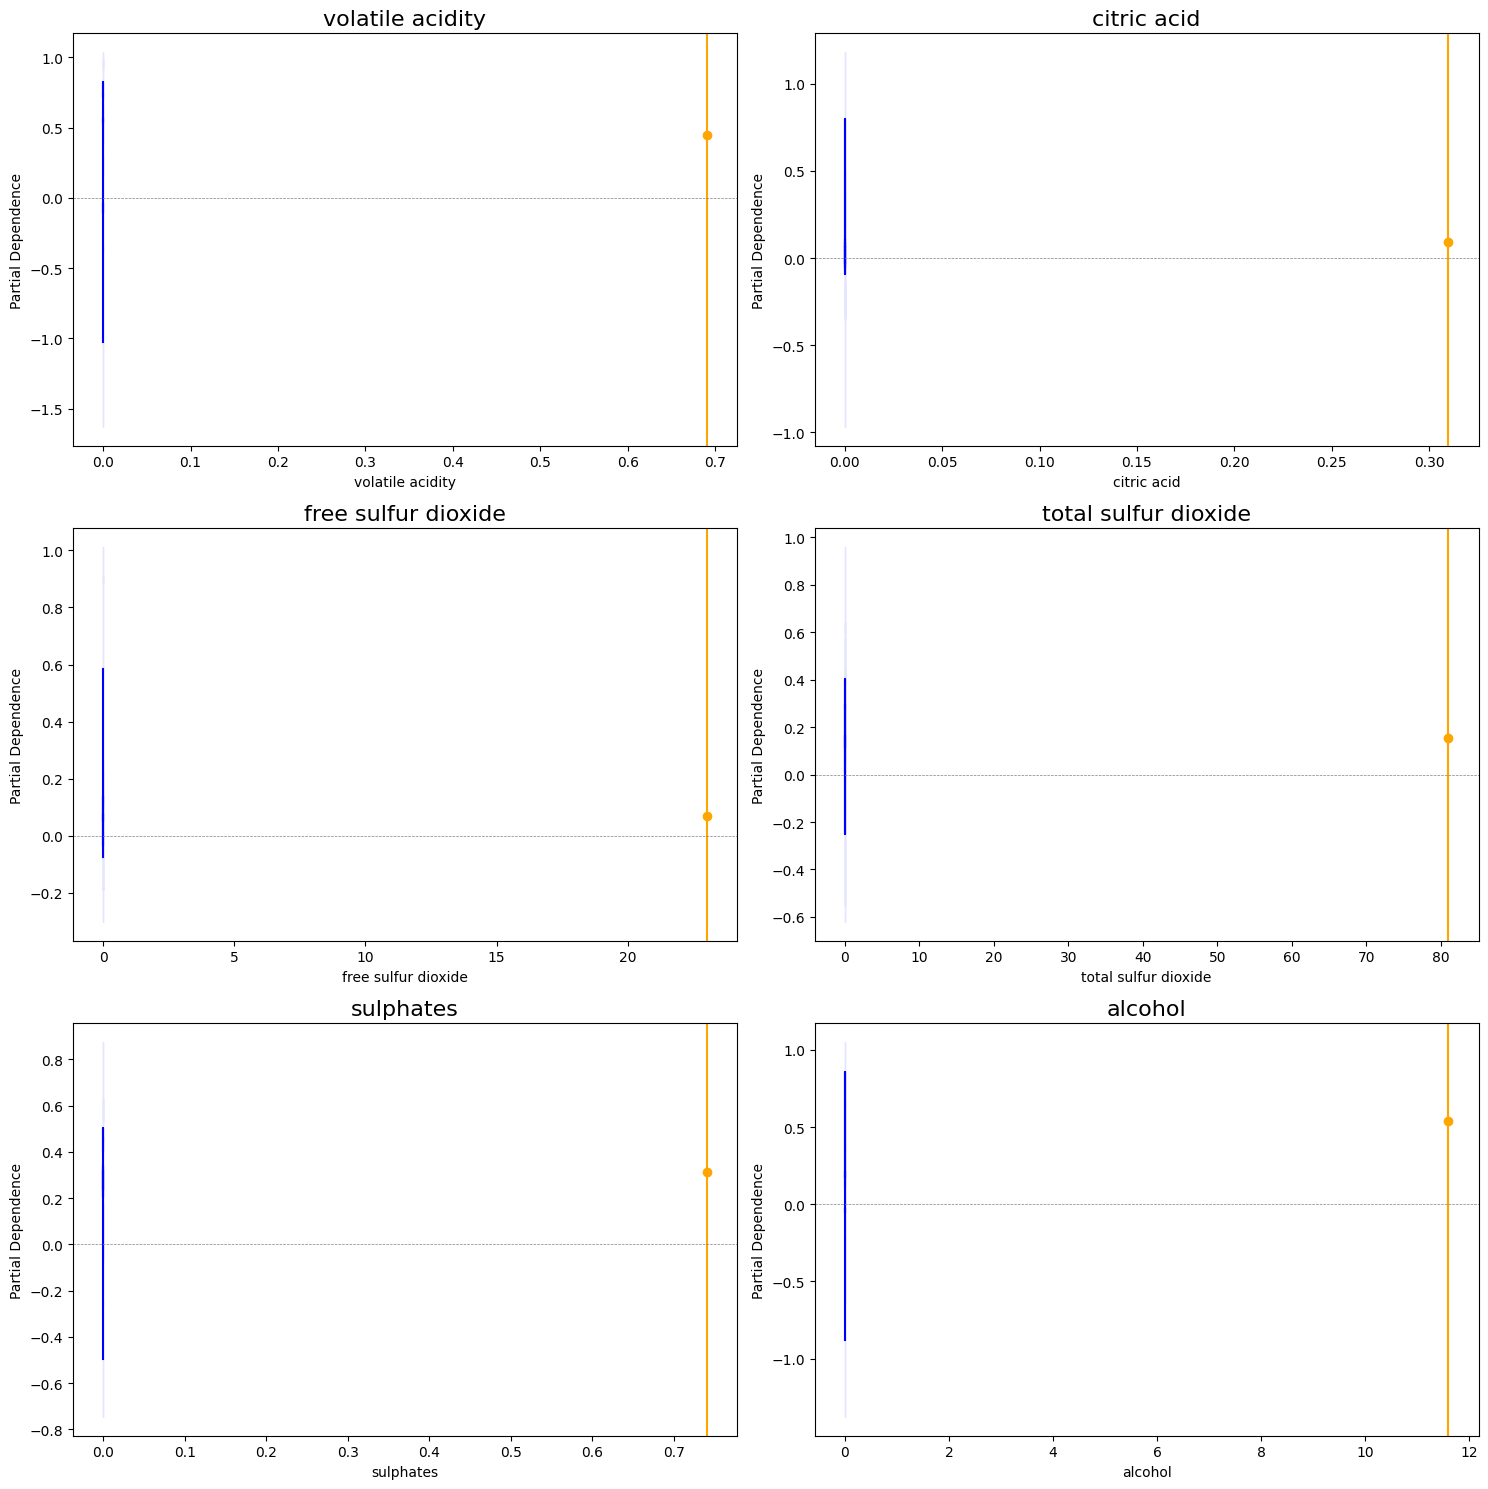

In [64]:
import matplotlib.pyplot as plt

def plot_gam_contributions(gam, instance, contributions, selected_features, selected_feature_indices):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()
    
    for idx, (feature, feature_idx) in enumerate(zip(selected_features, selected_feature_indices)):
        ax = axes[idx]
        XX = gam.generate_X_grid(term=feature_idx)
        pdep, confi = gam.partial_dependence(term=feature_idx, width=0.9)
        
        # 绘制形状函数和置信区间
        ax.plot(XX[:, 0], pdep, color='blue')
        ax.fill_between(XX[:, 0], confi[:, 0], confi[:, 1], alpha=0.1, color='blue')
        
        # 高亮实例的特定值在形状函数图上的位置
        color = 'orange' if contributions[idx][0] >= 0 else 'green'
        ax.axvline(instance[feature_idx], color=color, linestyle='-')
        ax.scatter(instance[feature_idx], contributions[idx][0], color=color)
        
        # 添加0的水平分界线
        ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
        
        ax.set_title(f'{feature}', fontsize=16)
        ax.set_xlabel(feature)
        ax.set_ylabel('Partial Dependence')
    
    plt.tight_layout()
    plt.show()

# 绘制特定特征的贡献
plot_gam_contributions(gam, instance, contributions, selected_features, selected_feature_indices)


In [8]:
xxs[1].shape

(100, 11)